![DLI Logo](../assets/DLI_Header.png)

In [1]:
%%html
<video controls src="https://d36m44n9vdbmda.cloudfront.net/assets/s-ds-03-v1/videos/assessments.mp4" 
width=800>assessments</video>

# Introduction

In this module, you will learn how to apply the building-block techniques we've covered to perform more holistic and useful security assessments of ML models.

## Learning Objectives:
1. How to use the [Adversarial Robustness Toolbox](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/) to attack local models and remote endpoints.
2. How to use [TextAttack](https://textattack.readthedocs.io/en/master/) to generate text-based attack strings.
3. How to use [Alibi](https://docs.seldon.io/projects/alibi/en/stable/) for explainability... and how explainability can be a useful security tool.

# Assessments
So far we've taken you through the raw and messy nature of ML and ML code. Implementing attacks is relatively straightforward once you understand how they work, though tedious. Fortunately, there are several tools out there that provide implementations of algorithms you can find in papers. We assume that many of you are being asked to "assess" models in some security capacity. Our goal in this lab is to help you generate the impact or outcome you are looking for in an efficient and repeatable way. These tools will be useful to you as those requests come in or compliance requirements start to take hold and technical testing standards shake out.

Currently, the space is such that a new vulnerability could end up having a direct effect on policy, possibly at the national level. However, until standards come out - we're kind of left to our own devices. While academia drops some pretty spicy research these days, it is far from having the operational sharpness red teams are used to. We don't necessarily know what those standards are yet, but we're not clueless as to what they _could_ be. For example, we already know that commonsense items like access control and input filtering will remain important. We can also be reasonably sure that issues that would normally be marked critical in a regular security context, would be marked the same if it affected an ML system. A model leaking PII is an issue, just the same as if any SQL injection vulnerability were the cause of a breach.  Getting code execution in an ML environment is still code execution. There are entirely too many analogies to discuss here.  Continue to apply what you already know know about security to ML deployments.

As with any assessment, know your audience. The attacks we've covered affect _ML deployments_, with results delivered to data scientists and ML engineers. This leads to some key assessment differences worth highlighting:

1. ML models are often probabilistic: they have some failure rate, so finding (e.g.) a single misclassified instance _simply isn't interesting_ to ML folks. 
2. Questions like "how many interactions with the model does it take to evade it?" or "what is the tradeoff between query budget and success rate?" are much more useful and help your audience contextualize the risk of your attack.
3. Data scientists and ML engineers often are not familiar with what you might consider basic principles like "minimize information" or "least privilege" -- by demonstrating that (for instance) hiding probabilities from a potential attacker greatly reduces the success rate, you can often convince them to take easy mitigations.

All of the above means that you need to speak to data scientists and ML engineers in their own language: data. Use something to log experiments exhaustively to generate the kind of statistics mentioned above, and _collaborate_ with them, try and learn the workflows, etc. These tools aren't necessarily easy to use, as they are designed for data acientists and ML engineers. There are some small adjustments you will need to make depending on your specific target. For example, 

- Not all APIs allow for batches, meaning you have to test one sample at a time, or create an internal batching mechanism. 
- Models are often hosted behind APIs that don't take arrays but take byte-streams. This requires you to implement a transformation process such that you can send the right data to the API, but also the algorithm you're using.
- Many attacks are iterative, if you get blocked halfway through an attack and the algorithm loses its state, you will likely need to restart the attack. Some may require many thousands of queries to complete. 

If you have direct access to the model you should use it; the time savings are going to be significant. If not, engineering and implementing an attack can still be extremely satifying. With that said, and tools in hand, we will say goodbye to writing attacks manually. I know you've enjoyed your time wrestling with it, but you are ready to move on.

# Imports and Model
We'll start by importing everything we need up top.

In [2]:
!pip install torch==2.3.0+cu121

ERROR: Could not find a version that satisfies the requirement torch==2.3.0+cu121 (from versions: 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1)
ERROR: No matching distribution found for torch==2.3.0+cu121


In [9]:
!pip install adversarial-robustness-toolbox==1.16.0

^C
     ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
     ---------------------------------------- 0.1/7.0 MB 1.1 MB/s eta 0:00:07
     - -------------------------------------- 0.3/7.0 MB 3.3 MB/s eta 0:00:03
     ---------- ----------------------------- 1.8/7.0 MB 12.6 MB/s eta 0:00:01
     ------------------------ --------------- 4.2/7.0 MB 22.4 MB/s eta 0:00:01
     ---------------------------------------  7.0/7.0 MB 29.5 MB/s eta 0:00:01
     ---------------------------------------- 7.0/7.0 MB 26.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "C:\Users\Usuario\Anaconda3\envs\llama\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\Usuario\Anaconda3\envs\llama\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\Usuario\Anaconda3\envs\llama\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "C:\Users\Usuario\Anaconda3\envs\llama\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
      obj = impor

In [4]:
import art
?art

Type:        module
String form: <module 'art' (namespace) from ['C:\\Users\\Usuario\\Anaconda3\\envs\\llama\\Lib\\site-packages\\art']>
Docstring:   <no docstring>

In [7]:
help(art)

Help on package art:

NAME
    art

PACKAGE CONTENTS
    attacks (package)
    config
    data_generators
    defences (package)
    estimators (package)
    evaluations (package)
    exceptions
    experimental (package)
    metrics (package)
    optimizers
    preprocessing (package)
    summary_writer
    visualization

FILE
    (built-in)




In [8]:
!pip install --upgrade setuptools

  Using cached setuptools-75.6.0-py3-none-any.whl.metadata (6.7 kB)
Using cached setuptools-75.6.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 70.1.1
    Uninstalling setuptools-70.1.1:
      Successfully uninstalled setuptools-70.1.1


In [1]:
# DO NOT CHANGE

import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import spacy
from alibi.datasets import load_cats
from alibi.explainers import AnchorImage
from IPython import display
import pandas as pd
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, BertForSequenceClassification
from textattack import Attack, Attacker
from textattack.attack_recipes import DeepWordBugGao2018
from textattack.datasets import Dataset
from art.attacks.evasion import CarliniL2Method, HopSkipJump
from art.estimators.classification import PyTorchClassifier, BlackBoxClassifier

# put the model on a GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Load our trusty target model.

In [3]:
# DO NOT CHANGE

target_model = torch.hub.load('pytorch/vision:v0.10.0', 
                              'mobilenet_v2', 
                              weights='MobileNet_V2_Weights.DEFAULT', 
                              verbose=False)
target_model.train()
target_model.to(device);

# Define the transforms for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]);

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

with open("../data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

img = Image.open("../data/dog.jpg")
img_tensor = preprocess(img).unsqueeze(0)
unnormed_img_tensor = unnormalize(img_tensor).to(device)

In [5]:
img.show()

# Adversarial Robustness Toolbox
The first tool we'll look at is the [Adversarial Robustness Toolbox (ART)](https://github.com/Trusted-AI/adversarial-robustness-toolbox). ART was primarily created to aid in the development of defenses against the rapidly evolving field of adversarial machine learning. It provides implementations of algorithms that come out of academia that we can use to attack a model. The framework provides an interface that is compatible with several ML libraries, including TensorFlow, PyTorch, Scikit-learn, etc. Most importantly, ART implements a [BlackboxClassifier class](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/estimators/classification.html#blackbox-classifier) that allows us to attack arbitrary endpoints.

## Attack Local Models
The easiest and most effective attacks are against model libraries, including PyTorch. We will use the `PyTorchClassifier` class to wrap our local model. Each model library class has helpful functions for loading and training models in ART. Each estimator has a handful of requirements that are common across these types of libraries, including the loss, number of classes, and the shape of the inputs, so that ART can interact with it.  We then define the attack, and use the `generate` method to produce an adversarial example. Finally, we'll visualize it as we did the previous attacks. For attacks in ART, the process is,

1. **Wrap the target model in an [ART estimator](https://github.com/Trusted-AI/adversarial-robustness-toolbox/wiki/ART-Estimators):** Because this is a `PyTorchClassifier`, it requires we give it a local file, a `loss` function, and the number of `labels` and `input_shape`. PAY ATTENTION TO THE `input_shape`. In this case, `input_shape` is a function of how the model was trained. When you attack an API endpoint by uploading an image in bytes, `input_shape` could be whatever you want. Similarly, the `labels` argument is used to get the right shape of the output, which again, when attacking API endpoints, is defined by you based on the information you get back from the API (`[0, 1]`. `0-1`, etc.).

In [6]:
# DO NOT CHANGE

classifier = PyTorchClassifier(
    model = target_model,
    loss = torch.nn.CrossEntropyLoss(),
    nb_classes = len(labels), # 1000
    input_shape = (3, 224, 224)
)

2. **Instantiate the attack**: Here we give the model to the attack. Attack methods will reference the classifier internally. This is why understanding shapes and how they're used in ML code is so important. 

In [7]:
# DO NOT CHANGE

attack = CarliniL2Method(classifier)

3. **Run the attack:** Each attack in ART has a special function signature depending on the attack. Here we are 'generating' adversarial examples. Also notice that we're converting our tensor to numpy? This is because ART's default dtype is `np.float32`, and internally this is what ART uses.

In [9]:
# DO NOT CHANGE

adversarial_example = attack.generate(img_tensor.numpy())

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

4. **Examine the results**: Here we convert the numpy `adversarial_example` back to a torch tensor, `adv_tensor`, then put it on the GPU (because that's where the target model is), and run it through the model. 

In [15]:
# DO NOT CHANGE

output_real = target_model(img_tensor.to(device))


print(f"Output real index:\n---------------\n{output_real[0].argmax()}\n")
print(f"Output real label:\n---------------\n{labels[output_real[0].argmax()]}\n")

Output real index:
---------------
235

Output real label:
---------------
German shepherd



In [10]:
# DO NOT CHANGE

adv_tensor = torch.tensor(adversarial_example).to(device)
output = target_model(adv_tensor)


print(f"Output index:\n---------------\n{output[0].argmax()}\n")
print(f"Output label:\n---------------\n{labels[output[0].argmax()]}\n")

Output index:
---------------
231

Output label:
---------------
collie



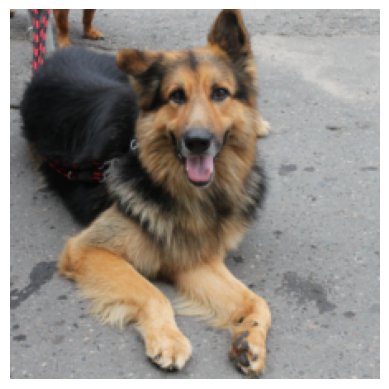

In [11]:
# DO NOT CHANGE

unnormed_adv_tensor= unnormalize(adv_tensor).to(device)

img_pil = transforms.functional.to_pil_image(unnormed_img_tensor[0])
plt.imshow(img_pil)
plt.axis('off')
plt.show()

Distance (L2 norm) between original image and masked image:
---------------
 0.4731547236442566


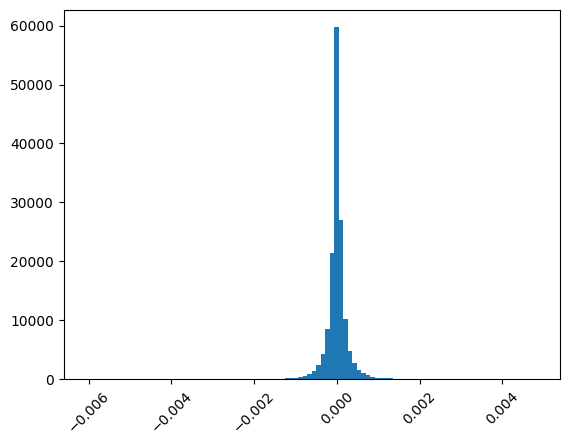

Minimum and maximum difference between the images: -0.0060599446296691895 0.00483858585357666


In [12]:
# DO NOT CHANGE

l2_norm = torch.norm(img_tensor.to(device) - adv_tensor, p=2)
print("Distance (L2 norm) between original image and masked image:\n---------------\n", l2_norm.item())

difference = unnormed_adv_tensor - unnormed_img_tensor
difference_list = difference.view(-1).tolist()

# Plot the histogram
plt.hist(difference_list, bins=100)
plt.xticks(rotation=45)
plt.show()

print("Minimum and maximum difference between the images:", difference.min().item(), difference.max().item())

Do you remember looking at this in the evasion lab? Recall how much more variance there was in our distributions? This is perhaps what we mean, use other people's tools. Unless you want to be optimizing algorithms instead of using them, don't write them by hand at first, use optimized implementations, _then_ learn how to do it yourself. Though, after that evasion lab, I don't think you'll argue with us on this one. 

## Attack Remote Models
In most practical cases when you're attacking a model behind an API, you need a general and flexible method to interact with that model. The `BlackBoxClassifier` interface is that method; you provide it with a single callable function that takes a numpy array as input and produces a numpy array as output. This _is_ where the rubber meets the road - this mechanism is what Counterfeit was built around. Even though this little bit of information is tucked away in this little section, the ability to attack arbitrary endpoints is pretty much why we're here. 

In this example, we're continuing to use our on-device model, but instead of calling the model directly via a `PyTorch` classifier, we will call it with a standalone function.

In [16]:
# DO NOT CHANGE

def predict(x):
    torch_tensor = torch.from_numpy(x).to(device)
    
    with torch.no_grad():
        output = target_model(torch_tensor)
    output = output.cpu().numpy()
    return output

You can put _any_ logic in here so long as you respect that  `x` _has_ to be a numpy array, which is set with `NUMPY_DTYPE` in the ART config, as that is what ART settled on; and that you must return a list of probabilities the same length as the number of labels you have (as we mentioned earlier).

Thanks to a unified interface, using the `HopSkipJump` attack is just a matter of defining a `predict` function and constructing the `BlackboxClassifier` class. 

_Note: The HopSkipJump attack in the following cell will take about two minutes to complete without displaying any progress indicators.  Don't be concerned if you don't see immediate output._

In [17]:
# DO NOT CHANGE

# set the input sample
img_tensor_hsj = img_tensor

# build the target
classifier = BlackBoxClassifier(
    predict_fn = lambda x:predict(x),
    nb_classes = len(labels),
    input_shape = img_tensor_hsj[0].shape
)

# instantiate the attack
attack = HopSkipJump(classifier)

# run the attacks
with torch.no_grad():
    hsj_adversarial_example = attack.generate(img_tensor_hsj.numpy())

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

And the by-now familiar visualization dance:

In [18]:
# DO NOT CHANGE

adv_tensor = torch.from_numpy(hsj_adversarial_example).to(device)
output = target_model(adv_tensor)

print(f"Output index:\n---------------\n{output[0].argmax()}\n")
print(f"Output label:\n---------------\n{labels[output[0].argmax()]}\n")

Output index:
---------------
193

Output label:
---------------
Australian terrier



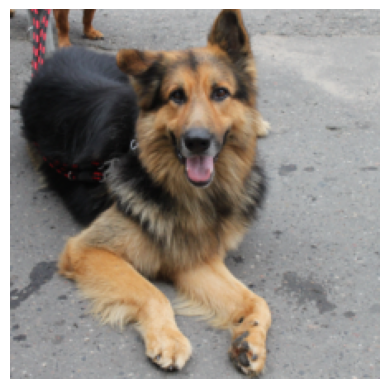

In [19]:
# DO NOT CHANGE

unnormed_adv_tensor= unnormalize(adv_tensor).to(device)

img_pil = transforms.functional.to_pil_image(unnormed_adv_tensor[0])
plt.imshow(img_pil)
plt.axis('off')
plt.show()

Distance (L2 norm) between original image and masked image:
---------------
 3.809051513671875


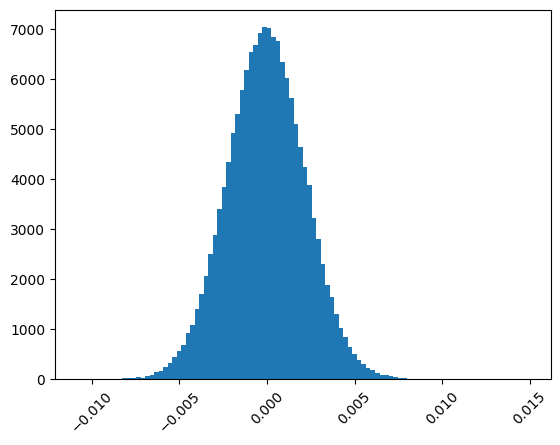

Minimum and maximum difference between the images: -0.010823473334312439 0.014919936656951904


In [20]:
# DO NOT CHANGE

l2_norm = torch.norm(img_tensor.to(device) - adv_tensor, p=2)
print("Distance (L2 norm) between original image and masked image:\n---------------\n", l2_norm.item())

difference = unnormed_adv_tensor - unnormed_img_tensor
difference_list = difference.view(-1).tolist()

# Plot the histogram
plt.hist(difference_list, bins=100)
plt.xticks(rotation=45)
plt.show()

print("Minimum and maximum difference between the images:", difference.min().item(), difference.max().item())

The powerful part about this implementation is that, as long as you satisfy input and output requirements imposed by ART (numpy in, numpy out), you can put any arbitrary logic in the middle. This opens up the possibility of attacking hosted models (or even processes that aren't models). Consider the following:

```python
# receive x as a numpy array from ART
def predict(x):
    # convert x to something to send the endpoint
    output = requests.post("http://127.0.0.1/predict", data=x)
    # convert output to something ART needs
    return np.array(output)
```

:::{exercise}
Instead of attacking a local model, we will attack the same model hosted on a local [flask](https://flask.palletsprojects.com/en/3.0.x/) webserver. This model, like many others, takes a base64 encoded bytes input rather than a tidy matrix. 

1. Open a Jupyter terminal.  You can open a terminal from a launch page or select _File→New→Terminal_ from the top menu bar.
2. Start the model server by typing the following in the Jupyter terminal:
   ```bash
   cd /dli/task/4_assessments
   python score.py
   ```
4. Write a predict function that allows ART to attack this model
5. Successfully run HopSkipJump against it. Take care to replace any variable names you may have changed.

_Hint: Don't forget the unnormalized step!_

```python
import requests
import base64
from PIL import Image
from io import BytesIO

img_hsj = Image.open("../data/dog.jpg")
img_tensor_hsj = preprocess(img_hsj).unsqueeze(0)

# Convert PIL image to bytes
buffer = BytesIO()
img_hsj.save(buffer, format="JPEG")
image_bytes = buffer.getvalue()

# Encode bytes using base64
encoded_image = base64.urlsafe_b64encode(image_bytes).decode('utf-8')

def send_encoded_image(encoded_image,url="http://127.0.0.1:2718/predict"):
    # Payload data for the POST request
    data = {
        'image': encoded_image
    }

    # Send the POST request
    response = requests.post(url, json=data)

    # Check the response status code
    if response.status_code == 200:
        # Request was successful
        return response.json()
    else:
        # Request failed
        print('Error:', response.text)
        return None


def predict(x):
    ...
```

:::

In [28]:
!pip install flask

   ---------------------------------------- 0.0/103.0 kB ? eta -:--:--
   --------------- ----------------------- 41.0/103.0 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 103.0/103.0 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/224.5 kB ? eta -:--:--
   ---------------------------------------- 224.5/224.5 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.0.3
    Uninstalling Werkzeug-3.0.3:
      Successfully uninstalled Werkzeug-3.0.3


In [26]:
# your code here
import requests
import base64
from PIL import Image
from io import BytesIO

img_hsj = Image.open("../data/dog.jpg")
img_tensor_hsj = preprocess(img_hsj).unsqueeze(0)

# Convert PIL image to bytes
buffer = BytesIO()
img_hsj.save(buffer, format="JPEG")
image_bytes = buffer.getvalue()

# Encode bytes using base64
encoded_image = base64.urlsafe_b64encode(image_bytes).decode('utf-8')

def send_encoded_image(encoded_image,url="http://127.0.0.1:2718/predict"):
    # Payload data for the POST request
    data = {
        'image': encoded_image
    }

    # Send the POST request
    response = requests.post(url, json=data)

    # Check the response status code
    if response.status_code == 200:
        # Request was successful
        return response.json()
    else:
        # Request failed
        print('Error:', response.text)
        return None

def predict(x):
    torch_tensor = torch.from_numpy(x).to(device)
    unnormed_adv_tensor= unnormalize(torch_tensor).to(device)
    
    # Convert PIL image to bytes
    buffer = BytesIO()
    img_hsj.save(buffer, format="JPEG")
    image_bytes = buffer.getvalue()
    encoded_image = base64.urlsafe_b64encode(image_bytes).decode("utf-8")

    # send the encoded image to the model endpoint
    resp = send_encoded_image(encoded_image)

    import sys
    amax = np.argmax(resp["probs"])
    sys.stdout.write(f'{resp["label"]}\t{resp["probs"][0][amax]}\r')
    return resp['probs']

In [29]:
# Run the attack and see if it worked

hosted_model = BlackBoxClassifier(
    predict_fn = lambda x:predict(x),
    nb_classes = len(labels),
    input_shape = img_tensor_hsj[0].shape
)

attack = HopSkipJump(hosted_model)

with torch.no_grad():
    hsj_adversarial_example = attack.generate(img_tensor_hsj.numpy())

# Check the adversarial prediction
predict(hsj_adversarial_example)


HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to draw a random image that is adversarial, attack failed.


[[1.3147445315553341e-05,
  3.9675575180808664e-07,
  1.066510293412648e-07,
  8.176468924148139e-08,
  1.2914838976030296e-08,
  1.83975828349503e-07,
  1.87301480991664e-08,
  2.282111609019921e-06,
  2.1137345811439445e-06,
  1.2859876719062413e-08,
  8.310396282240617e-08,
  1.1032135205368832e-07,
  1.607063104813733e-08,
  3.3732101556438465e-09,
  5.966156777503784e-07,
  7.578151439702197e-09,
  2.9522901900946863e-09,
  1.1272030064901628e-07,
  4.6082138105418835e-09,
  2.0151819768443602e-08,
  1.2771852908599612e-08,
  9.01128327512879e-09,
  2.536358678639772e-09,
  1.736450272460388e-08,
  1.922873638093847e-09,
  1.861195414676331e-06,
  7.81474170707952e-07,
  1.1322144928271882e-06,
  1.996434093598509e-06,
  2.898432782671989e-08,
  1.5444177279277937e-06,
  1.0529657856750418e-07,
  2.5164615635731025e-06,
  5.245153147370729e-07,
  9.490693173574982e-07,
  3.9644920235559766e-08,
  6.002067465260552e-08,
  2.8408056351736377e-08,
  1.0736629718621771e-07,
  3.164164

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.0091617].


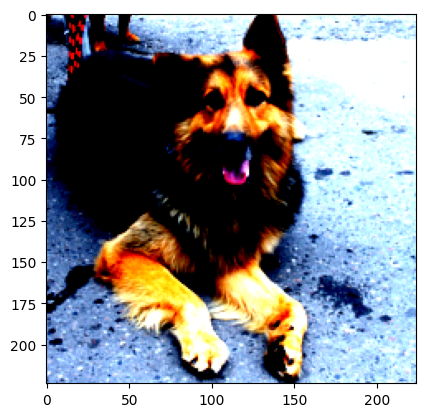

In [30]:
# visualize the example
img = hsj_adversarial_example.squeeze(0)
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

**The solution can be found in the [answer key](answers-1_assessments.ipynb), if you need it.**

Not so fast, this is where it can get a bit tricky. Some of you may have noticed that this attack isn't _truly_ blackbox, as we share the labels file with our target model. This is potentially a non-issue if you are confident of the base model or you were given the labels as part of an assessment. Otherwise, you may not know what the outputs are, or as mentioned earlier a model might have 1000 labels but only returns the top 5. 

This presents a challenge for our attack as the random images generated are likely to return a different top 5 each time. Recall that models have no real concept of "labels", they don't know `output[0]` is a `dog`. However, this is now equally true for us -- maybe there are a million labels our target model is pulling from. We don't know. So what labels can we use for ART? We'll have to come up with our own and there are two primary solutions. 

We know we have a `German Shepherd` as our sample, and in an untargeted attack we're happy with any other output. Which means there are effectively only 2 classes we care about -- the thing we have, and everything else. In ART this looks like, `nb_classes=2` when you create the `BlackboxClassifier` class. However, your `predict` will now return more values than ART is expecting, and you would need to update it. But, these are the labels we're giving to ART, `[thing we have, everything else]`. When we return values from the `predict` function we need to remember which index is which label and construct the outputs accordingly.

- **Solution 1:** As you process the output from the model construct a list of `[1-probability, probability]`. This is nice because it you can turn it into a targeted attack quickly, if you know the specific label you want.

```python 
nb_classes=2

def predict(x):
    ...
    return [[1-top_label, top_label]]
```


- **Solution 2:** As you process the output from a model with top-k labels, first calculate `remainder = 1-probability/k` where `k` is the number of labels you get back. Then construct a list of `[probability, remainder, remainder, remainder, remainder]`. This is nice because it deals with shifting labels among a top-k output without needing to keep track of specific labels. 


```python
nb_classes=3

def predict(x):
    ...
    return [[top_label, leftover, leftover]]
```

:::{exercise} Challenge

You will find these strategies useful in many places, including this exercise! Try Solution 1 from above with the provided `score_top_1.py` 

1. Exit out of the previous server in your Jupyter terminal with CTRL+C.
2. Start a new hosted model by typing `python score_top_1.py` in the Jupyter terminal.
3. Rewrite the predict function with the relevant strategy in mind.
4. Rerun the attacks

:::

In [ ]:
# your code here

In [ ]:
# Run the attack and see if it worked

hosted_model = BlackBoxClassifier(
    predict_fn = lambda x:predict(x),
    nb_classes = 2,
    input_shape = img_tensor_hsj[0].shape
)

attack = HopSkipJump(hosted_model)

with torch.no_grad():
    hsj_adversarial_example = attack.generate(img_tensor_hsj.numpy())

# Check the adversarial prediction
predict(hsj_adversarial_example)

In [ ]:
# visualize the example
img = hsj_adversarial_example.squeeze(0)
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

**The solution can be found in the [answer key](answers-1_assessments.ipynb), if you need it.**

You will find these strategies (especially Solution 1) useful in all kinds of places. For adversarial attacks specifically, having performance baselines helps gauge the severity and success rate of attacks. Tracking attack success metrics over time for a model provides a baseline to aim for when developing defenses. Creating benign accuracy baselines on clean data is also useful context when evaluating performance on adversarial samples. A significant drop from baseline would indicate some sort of regression in the model, or potentially new threat or technique that has been released.

# TextAttack
TextAttack is a Python framework for adversarial attacks in the textual domain. While we can and absolutely have run algorithms like `HopSkipJump` against text, it can be a little painful, and is truly not ideal. Textual attacks effectively operate in the same way as the image attacks - there's some number we want to move up or down by changing the input in a particular way. The difference between images and text is that text is not a continuous function. Changes in the input isn't necessarily proportional to a change in the output, making perturbation to the input harder to measure. Consider the following: 

1. My house is on fire
2. My house is on earth

These two sentences would be close in the input space, their tokenized values would be the same except for the final word. Though, semantically they each mean two completely different things. Whereas with an image, changing a _single_ pixel wildly up or down is unlikely to have the same proportional affect on the output. We're not quite ready to get into the wordy weeds yet, but keep that in mind as you think about these attacks as they relate to the surge of interest in Large Language Models (LLMs). 

First, we'll load a target model. We're again using HuggingFace to load a model. We tokenize a sentence. (I know we've covered it already but think of `tokenizer` like `preprocess` from our `MobileNetV2` model above).

In [ ]:
# DO NOT CHANGE

# load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity")

# tokenize
good_input = tokenizer("This is a good thing", return_tensors="pt")
bad_input = tokenizer("This is a bad thing", return_tensors="pt")

# run inference
with torch.no_grad():
    good_logits = model(**good_input).logits
    bad_logits = model(**bad_input).logits


# get the results
good_class_id = good_logits.argmax().item()
bad_class_id = bad_logits.argmax().item()

print(f"Good class id:\n---------------\n{model.config.id2label[good_class_id]}\n")
print(f"Bad class id:\n---------------\n{model.config.id2label[bad_class_id]}\n")

This model is a pretrained machine learning model for text classification tasks. It is based on the BERT (Bidirectional Encoder Representations from Transformers) architecture and has been fine-tuned specifically for polarity detection tasks on Yelp reviews. Yelp Polarity is a popular dataset for sentiment analysis tasks where the objective is to classify text into two classes: `positive` or `negative` sentiment. This is basically the same as the BERT models we trained earlier, but for a different task!

Great, a working sentiment classifier. One thing to note from above is how inputs are put into the model: `logits = model(**inputs).logits`. `**inputs` unpacks the `inputs`, but why would it need to do this? Let's take a look.

In [ ]:
# DO NOT CHANGE

print(f"Good input info:\n---------------\n{good_input}\n")
print(f"Bad input info:\n---------------\n{bad_input}\n")

As a reminder (from the extraction lab), `inputs` is a dictionary of _multiple_ arrays that make up a single sample. This is a key difference between image classifiers and text models or generative models. 

The keys represents:

1. `input_ids`: These are the tokenized representations of the input text. Each integer represents a specific token in the model's vocabulary. For instance, in your example, the `input_ids` tensor includes the tokens for a specific sentence. The numbers `101` and `102` are special tokens, representing the start (`[CLS]`) and end (`[SEP]`) of a sequence, respectively.
2. `token_type_ids`: These are used in models that need to understand two separate sentences and how they interact (for example, in a question-answering model or a next-sentence prediction model). They differentiate between the two sentences. In this case, all the token_type_ids are `0`, meaning that all the tokens belong to the same sentence. If there were two sentences, you'd see a sequence of `0`s (for the first sentence) followed by a sequence of `1`s (for the second sentence).
3. `attention_mask`: This is used to specify which tokens should be attended to by the model, and which should be ignored. A value of `1` means the token should be attended to, and a value of `0` means the token should be ignored. This is usually used when we have padded sequences (to make all inputs the same length) and we want the model to ignore the padding tokens. In your example, all values in the `attention_mask` tensor are `1`, which indicates that all tokens in `input_ids` should be considered by the model.

These "extra" inputs are effectively just a way for us to provide a model contextual information. But they also represent an attack surface! 

Now let's go through setting up a TextAttack attack against this model. As you might have guessed, TextAttack has a similar build pipeline to ART. However, it doesn't have a similar `BlackboxClassifier` class. So, we'll just create one.

In [ ]:
# DO NOT CHANGE

class TextAttackWrapper(object):
    def __init__(self, model):
        self.model = model

    def __call__(self, x):
        inputs = tokenizer(x, return_tensors="pt", padding=True)
        with torch.no_grad():
            output = model(**inputs)
            probs = output.logits.softmax(dim=-1).numpy()
        return probs

Instead of the `predict` function that we used in ART, TextAttack uses the `__call__` method to query a model. Otherwise, the mechanics are the same. 

Like ART, TextAttack requires input data to be structured a particular way, a list of tuples where each tuple consists of `(input, label)` and stored in a `Dataset` class, which is mostly just a container.

In [ ]:
# DO NOT CHANGE

data = [("I enjoyed the movie a lot!", 1), ("Absolutely horrible film.", 0), ("Our family had a fun time!", 1)]
dataset = Dataset(data)  

Then we build the attack. Attacks in TextAttack have a particular naming convention - `attack name` + `the author` + `the year when the research paper was released`. 

In [ ]:
# DO NOT CHANGE

model_wrapper = TextAttackWrapper(model)

Because we're wrapping a model, TextAttack will warn us that our model might not be compatible with the attack we have chosen. Remember that most tools expect you have a local model file. 

In [ ]:
# DO NOT CHANGE

attack = DeepWordBugGao2018.build(model_wrapper)
attack.attack

Here, we can see the functions the attack is comprised of, this will also print when we run the attack. Faithful to their documentation, we can review the four primary components of an attack module (these should all be familiar sounding)

- `Goal function`: The goal function determines if the attack is successful or not. One common goal function is untargeted classification, where the attack tries to perturb an input to change its classification.
- `Search method`: The search method explores the space of potential transformations and tries to locate a successful perturbation. Greedy search, beam search, and brute-force search are all examples of search methods.
- `Transformation`: A transformation takes a text input and transforms it, for example replacing words or phrases with similar ones, while trying not to change the meaning. Paraphrase and synonym substitution are two broad classes of transformations.
- `Constraints`: Finally, constraints determine whether or not a given transformation is valid. Transformations don’t perfectly preserve syntax or semantics, so additional constraints can increase the probability that these qualities are preserved. This might include constraints that -  overlap constraints that measure edit distance, syntactical constraints check part-of-speech and grammar errors, and semantic constraints. Or _even_ execution constraints that we explored in the malware evasion lab.

Finally, we build and run the attack.

In [ ]:
# DO NOT CHANGE

attacker = Attacker(attack, dataset)
attacker.attack_dataset()

The nice part about TextAttack is that is has some built-in success metrics, which again, is useful for benchmarking as it applies to the various techniques you would use, old and new.

In [ ]:
# DO NOT CHANGE

probs = model_wrapper("Absolutely horrible film.")
for i, prob in enumerate(probs[0]):
    print(f"Probability of class {i}:\n---------------\n{prob * 100:.2f}%\n")
    
adv_probs = model_wrapper("Absolutely hrorible film.")
for i, adv_probs in enumerate(adv_probs[0]):
    print(f"Probability of class {i} (adv example):\n---------------\n{adv_probs * 100:.2f}%\n")

Just by changing the spelling of a word, you can completely flip the label on a reasonably popular sentiment classifier model. Because we've spent so much time working with these attacks, you probably already have a pretty good idea about how it works, despite the model being a completely different modality. But it makes sense the label would change, because it's not the same word, even if we as humans can correct for it. 

# Alibi

One of the sections in our methodology is 'Harm & Abuse'. This is maybe a new category of concerns for security people, and it's an important one in the realm of ML as it relates to the deployment of models. For example, research and the news has shown several examples of harm and abuse stemming from models. While the flashy articles tend to highlight existential threats invoking images of Terminator, the reality is that in some severe cases, we see issues such as:

- People of color being falsely arrested because of facial recognition technology
- People of color having _measurably worse_ clinical outcomes
- People of different ethnicities not being able to have their language accurately translated
- Women being depicted in a stereotypical way
- The list goes on...

Alibi is a library of "explainability" algorithms for detecting anomalies and explaining model predictions. Ideally, with the right processes in place prior to release you should try to eliminate _some_ of the scenarios above. Alibi aims to make ML models more transparent and trustworthy. For example -

- Detect when new data looks unusual compared to past data the model was trained on. This is helpful for catching errors or changes in the data.
- Explain why a machine learning model made a certain prediction. For example, which features of an image were most important for predicting it shows a dog.
- Make sure dataset biases are not negatively impacting model fairness. For example, checking if a model makes equally accurate predictions for different demographic groups.
- Quantify how confident a model is for each prediction.

These techniques can also be used to hone other attacks, as we will see. Perhaps a particular area of an image is more important to a model than other areas. For example, a model has learned the difference between a `horse` and a `zebra` by focusing on stripes and the mane. An explainability algorithm might allow you to capitalize on this insight. 

## Explaining Images
Alibi can do both text and images, lets do images first. The build process is again similar to both of the above frameworks, in which we pass a model to some class that interacts with the model to do whatever it's supposed to. `segmentation_fn` is the algorithm we want to use, and `kwargs` can be thought of as hyperparameters. With these we can build an `explainer`.

In [ ]:
# DO NOT CHANGE

def predict(x):
    torch_tensor = torch.from_numpy(x).to(device)
    # we're going to assume the incoming image is shape [1,w,h,c] and convert it to [1,c,w,h]
    torch_tensor = torch.moveaxis(torch_tensor, 3, 1)
    # print(torch_tensor.shape)
    with torch.no_grad():
        output = target_model(torch_tensor)
        output = output.cpu().numpy()
    return output

In [ ]:
# DO NOT CHANGE
img = np.moveaxis(unnormalize(img_tensor[0]).numpy(), 0, 2)

explainer = AnchorImage(
    predict, 
    image_shape=img.shape,
    segmentation_fn='slic',
    segmentation_kwargs={'n_segments': 30, 'compactness': 50, 'sigma': .1, 'start_label': 0,
                        'channel_axis':-1},
    images_background=None
)

The goal is to understand why a machine learning model makes a particular prediction on an image. To do this, `AnchorImage` breaks the image up into pieces called superpixels - think of these as little puzzle pieces of the image. It then starts removing or hiding different superpixel pieces of the image, and sees how much that changes the model's prediction.

The superpixel pieces that change the prediction a lot when removed are considered highly "influential" - meaning they contain visual patterns that the model relies on for the prediction. `AnchorImage` identifies the top most influential superpixel pieces. These influential pieces are called the "anchors" - they anchor the prediction locally to the image. By highlighting these anchor superpixels, we can visualize and understand the patterns in the image that drive the model's decision.

The `segmentation_kwargs`:

- The image is segmented into 30 superpixels, controlled by `n_segments`.
- `compactness` and sigma affect how cleanly the superpixels are divided.
- `start_label=0` just means the first label for a superpixel is `0`.
- No background images are provided, so influence is calculated against a blank background.


:::{figure} ../assets/alibi_images.png
:height: 250x
:name: achors
:align: center
Ribeiro et al., Anchors: High-Precision Model-Agnostic Explanations, 2018
:::

In [ ]:
# DO NOT CHANGE

explanation = explainer.explain(img, threshold=.99, p_sample=.5, tau=0.25)

The goal is to have the AnchorImage explainer identify the influential superpixels in the image that drive the model's prediction. That line is running AnchorImage on the first image (img_tensor[0]) to generate the explanation. Some key parameters it passes:

- threshold=.99 - This filters for only the most influential superpixels that really anchor the prediction. Basically, it'll ignore superpixels that don't drastically change the prediction when removed.
- p_sample=.5 - Only look at 50% of superpixels randomly. This makes the process faster by not analyzing every single piece.
- tau=0.25 - When a superpixel is influential, also give some influence to its neighbors. This spreads out the highlighting a bit.

The output will be the original image, with the influential superpixels visualized based on their importance to the prediction. The highlighted areas indicate visual patterns that the model strongly relies on when making that prediction. Seeing these influential superpixels helps explain what the model is responding to and why it makes that particular prediction.

Then we can view what the `explanation` for it being a `German Shepherd` is. The blank lines can be removed, and the model still thinks it's a `German Shepherd`

In [ ]:
# DO NOT CHANGE

plt.imshow(explanation.anchor)

## Alibi - Text
And we can do the same with text. Again, the goal is to identify important words that lead the model to make a particular prediction when we send something for inference. `AnchorText` will take a piece of text and start masking or removing words in it. It tracks how much each word affects the model's prediction when it's masked.  Words that change the prediction a lot when masked are considered influential or important. These words "anchor" the prediction. `AnchorText` marks these influential words as anchors to show what the model relies on most when making that prediction.

In [ ]:
# DO NOT CHANGE

from alibi.utils import spacy_model

model = 'en_core_web_md'
spacy_model(model=model)
nlp = spacy.load(model)

In [ ]:
# DO NOT CHANGE

tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity")

def predict(x):
    inputs = tokenizer(x, return_tensors="pt", padding=True)
    with torch.no_grad():
        output = model(**inputs)
    return output.logits.numpy()

In [ ]:
# DO NOT CHANGE

from alibi.explainers import AnchorText
explainer = AnchorText(
    predictor=predict,
    sampling_strategy='unknown',
    nlp=nlp
)

In [ ]:
# DO NOT CHANGE

text = "My dear aunt Sally loved this movie"

pred = predict(text)
predicted_class_id = pred.argmax().item()
model.config.id2label[predicted_class_id]

In [ ]:
# DO NOT CHANGE

explanation = explainer.explain(text, threshold=0.85)

Words that reduce the prediction score by `>= 0.95` (the threshold) when masked are considered highly influential anchors, and `sampling_strategy='unknown'` means `AnchorText` will sample words more broadly. 

In [ ]:
# DO NOT CHANGE

print(f"Anchor: {explanation.anchor}")
print(f'Precision: {explanation.precision:.2f}\n')

print(f"Examples where anchor applies and model predicts: {predicted_class_id}\n---------------\n")
print('\n'.join([x for x in explanation.raw['examples'][-1]['covered_true']])) 
print(f"\nExamples where anchor applies and model predicts: 0\n---------------\n")
print('\n'.join([x for x in explanation.raw['examples'][-1]['covered_false']]))

:::{exercise}
As alluded to earlier, you won't always get probabilities and that requires modifications to your code. 

1. Create a list that contains more than one text sample
2. Make a simple modification to the `explainer` to deal with `0` or '1' (discrete) outputs
3. (Optional) Figure out how to use this against SOREL-20, or a copy-cat model.

```python
explanation = explainer.explain(text, threshold=0.95)
```

In [ ]:
# your code here

# Conclusion
That was a whirlwind tour through three extremely useful and functional tools - ART, TextAttack, and Alibi. The lack of explanation regarding the specifics of each tool or technique is somewhat intentional. We could, as we did in the early labs, have you build each of the above by hand, go through the nitty-gritty implementation details, deal with all the errors, etc. However, the reality is there are so many different techniques and use cases we could never cover all of them -- and you already know the nitty-gritty implementation details as a result of the previous two labs. Yet somehow, despite everything we've covered so far, there are _still_ more ways to assess and measure an model. We recommend you dig into these tools later. In our view having a basic working knowledge of the fundamentals is more important than running tools anyway. 

In the next lab, we'll look at using Optuna to fine-tune attacks under whatever constraints might be present.

## What You Learned

1. How to apply theoretical attacks to more applied ML security assessments.
2. How to use the `Adversarial Robustness Toolbox` to attack local models and remote endpoints.
3. How to use `TextAttack` to generate text-based attack strings.
4. How to use `Alibi` for explainability... and how explainability can be a useful security tool.

**Head into the [next lab](2_optuna.ipynb)**.

![DLI Logo](../assets/DLI_Header.png)